### First We start with the imports

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
#we will use pytorch for the neural network here
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import os
import copy
from sklearn.model_selection import train_test_split
import shutil
from pathlib import Path
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")






### Image Preprocessing

In [4]:
#now will process the image to fit the model specs
transform = transforms.Compose([
    transforms.Resize((224, 224)), transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) ], 
    )
#load the data


In [5]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_dir = 'Dataset_BUSI_with_GT'

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])]),

    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])])
}

def split_dataset(dataset_path, output_dir='BUSI_split', val_size=0.2):
    classes = ['benign', 'malignant', 'normal']
    os.makedirs(output_dir, exist_ok=True)
    for cls in classes:
        images = list(Path(dataset_path, cls).glob("*.png"))
        train_imgs, val_imgs = train_test_split(images, test_size=val_size, random_state=42)
        for phase, img_list in zip(['train', 'val'], [train_imgs, val_imgs]):
            phase_path = Path(output_dir) / phase / cls
            phase_path.mkdir(parents=True, exist_ok=True)
            for img in img_list:
                shutil.copy(img, phase_path / img.name)

# split_dataset('Dataset_BUSI_with_GT')

data_dir = 'BUSI_split'

image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
    for x in ['train', 'val']
}
dataloaders = {
    x: DataLoader(image_datasets[x], batch_size=16, shuffle=True)
    for x in ['train', 'val']
}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 3)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)

def train_model(model, criterion, optimizer, num_epochs=5):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}\n{'-'*20}")
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            running_loss = 0.0
            running_corrects = 0
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
    print(f"\nBest val Acc: {best_acc:.4f}")
    model.load_state_dict(best_model_wts)
    return model


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:

model = train_model(model, criterion, optimizer, num_epochs=20)
torch.save(model.state_dict(), 'resnet18_busi.pth')




Epoch 1/20
--------------------
train Loss: 0.8366 Acc: 0.6198
val Loss: 0.5965 Acc: 0.7893

Epoch 2/20
--------------------
train Loss: 0.5688 Acc: 0.7706
val Loss: 0.4858 Acc: 0.7956

Epoch 3/20
--------------------
train Loss: 0.4879 Acc: 0.8079
val Loss: 0.4227 Acc: 0.8239

Epoch 4/20
--------------------
train Loss: 0.4758 Acc: 0.8087
val Loss: 0.4117 Acc: 0.8208

Epoch 5/20
--------------------
train Loss: 0.4465 Acc: 0.8262
val Loss: 0.3966 Acc: 0.8459

Epoch 6/20
--------------------
train Loss: 0.4125 Acc: 0.8389
val Loss: 0.3556 Acc: 0.8428

Epoch 7/20
--------------------
train Loss: 0.4039 Acc: 0.8468
val Loss: 0.3610 Acc: 0.8491

Epoch 8/20
--------------------
train Loss: 0.3855 Acc: 0.8476
val Loss: 0.3477 Acc: 0.8396

Epoch 9/20
--------------------
train Loss: 0.3829 Acc: 0.8421
val Loss: 0.3365 Acc: 0.8491

Epoch 10/20
--------------------
train Loss: 0.3769 Acc: 0.8492
val Loss: 0.3261 Acc: 0.8711

Epoch 11/20
--------------------
train Loss: 0.4117 Acc: 0.8413
val 

In [7]:
#print the confusion matrix 
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    



Confusion matrix, without normalization
[[169   6   4]
 [ 16  67   2]
 [ 10   3  41]]


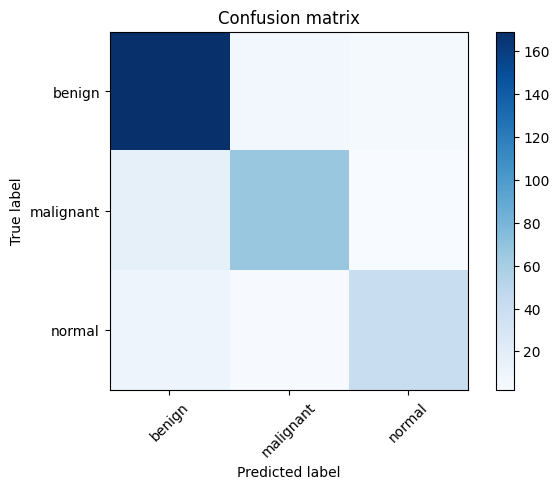

              precision    recall  f1-score   support

      benign       0.87      0.94      0.90       179
   malignant       0.88      0.79      0.83        85
      normal       0.87      0.76      0.81        54

    accuracy                           0.87       318
   macro avg       0.87      0.83      0.85       318
weighted avg       0.87      0.87      0.87       318



In [8]:
#evaluate the model
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in dataloaders['val']:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
cm = confusion_matrix(all_labels, all_preds)
# Plotconfusion matrix
plt.figure()
plot_confusion_matrix(cm, classes=class_names, title='Confusion matrix')
plt.savefig('confusion_matrix.png')
plt.show()
#classification report
print(classification_report(all_labels, all_preds, target_names=class_names))


In [9]:
#now i will try mobilenetv2
from torchvision import models
model = models.mobilenet_v2(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, 3)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier[1].parameters(), lr=0.001)
model_mobilenet = train_model(model, criterion, optimizer, num_epochs=20)
torch.save(model_mobilenet.state_dict(), 'mobilenetv2_busi.pth')


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Epoch 1/20
--------------------
train Loss: 0.6749 Acc: 0.7008
val Loss: 0.4646 Acc: 0.8270

Epoch 2/20
--------------------
train Loss: 0.4981 Acc: 0.8016
val Loss: 0.4779 Acc: 0.8176

Epoch 3/20
--------------------
train Loss: 0.4697 Acc: 0.8087
val Loss: 0.4298 Acc: 0.8239

Epoch 4/20
--------------------
train Loss: 0.4333 Acc: 0.8246
val Loss: 0.3760 Acc: 0.8396

Epoch 5/20
--------------------
train Loss: 0.4502 Acc: 0.8143
val Loss: 0.3970 Acc: 0.8145

Epoch 6/20
--------------------
train Loss: 0.3857 Acc: 0.8492
val Loss: 0.4117 Acc: 0.8270

Epoch 7/20
--------------------
train Loss: 0.3844 Acc: 0.8500
val Loss: 0.3596 Acc: 0.8459

Epoch 8/20
--------------------
train Loss: 0.4122 Acc: 0.8341
val Loss: 0.3585 Acc: 0.8459

Epoch 9/20
--------------------
train Loss: 0.3961 Acc: 0.8429
val Loss: 0.3388 Acc: 0.8679

Epoch 10/20
--------------------
train Loss: 0.4027 Acc: 0.8270
val Loss: 0.3620 Acc: 0.8585

Epoch 11/20
--------------------
train Loss: 0.4100 Acc: 0.8254
val 

Confusion matrix, without normalization
[[167   8   4]
 [ 19  65   1]
 [  8   2  44]]


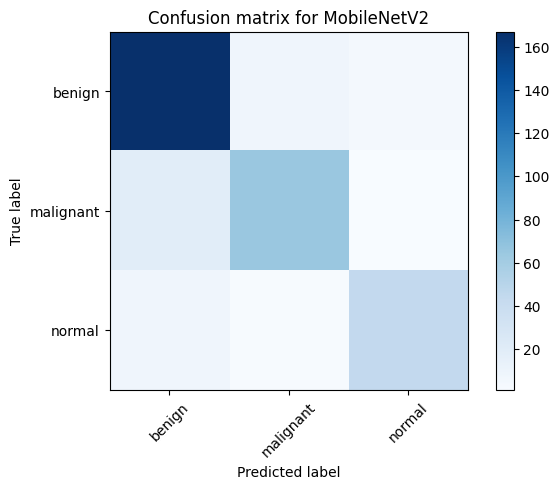

              precision    recall  f1-score   support

      benign       0.86      0.93      0.90       179
   malignant       0.87      0.76      0.81        85
      normal       0.90      0.81      0.85        54

    accuracy                           0.87       318
   macro avg       0.88      0.84      0.85       318
weighted avg       0.87      0.87      0.87       318



In [10]:

#evaluate the model
model_mobilenet.eval()
all_preds_mobilenet = []
all_labels_mobilenet = []
with torch.no_grad():
    for inputs, labels in dataloaders['val']:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model_mobilenet(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds_mobilenet.extend(preds.cpu().numpy())
        all_labels_mobilenet.extend(labels.cpu().numpy())
cm_mobilenet = confusion_matrix(all_labels_mobilenet, all_preds_mobilenet)
# Plot  confusion matrix
plt.figure()
plot_confusion_matrix(cm_mobilenet, classes=class_names, title='Confusion matrix for MobileNetV2')
plt.savefig('confusion_matrix_mobilenet.png')
plt.show()
# Print classification report
print(classification_report(all_labels_mobilenet, all_preds_mobilenet, target_names=class_names))



In [1]:
from colabcode import ColabCode

ModuleNotFoundError: No module named 'colabcode'